In [8]:
import learn_kuramoto_files as lk
import numpy as np
import importlib as imp
import pandas as pd
import time
from scipy import signal
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix,vstack,hstack
from scipy.sparse.linalg import spsolve
imp.reload(lk)

<module 'learn_kuramoto_files' from 'C:\\Users\\mpanaggio\\Box\\MRC\\learn_model_fourier\\learn_network_structure\\learn_kuramoto_files.py'>

In [9]:
##############################################################################
## define model parameters
num_osc=10
mu_freq=0.0  # mean natural frequency
sigma_freq=0.5 # std natural frequency
p_erdos_renyi=0.5  # probability of connection for erdos renyi
random_seed=-1 # -1 to ignore
coupling_function=lambda x: np.sin(x)#+0.1*np.sin(2*(x+0.2))   # Gamma from kuramoto model
#coupling_function=lambda x: np.sin(x-0.2)+0.1*np.cos(2*x) # Gamma from kuramoto model

##############################################################################
## define numerical solution parameters
dt=0.1     # time step for numerical solution
tmax=50*dt    # maximum time for numerical solution
noise_level=0.0 # post solution noise added
dynamic_noise_level=0 # post solution noise added
num_repeats=20#10 # number of restarts for numerical solution
num_attempts=1#5 # number of times to attempt to learn from data for each network
num_networks=1#10 # number of different networks for each parameter value
method='euler' #'rk2','rk4','euler',
with_vel=True
## Note: the  loop parameter value will overwrite the value above

In [10]:
show_plots=False
# A_true=np.matrix(np.ones((3,3))-np.eye(3))
# A_true[1,2]=0
# A_true[2,1]=0
# print(A_true)
system_params={'w': lk.random_natural_frequencies(num_osc,mu=mu_freq,sigma=sigma_freq,seed=random_seed),
        'A': lk.random_erdos_renyi_network(num_osc,p_value=p_erdos_renyi,seed=random_seed),
        'K': 1.0,
        'Gamma': coupling_function,
        }
solution_params={'dt':dt,
                 'tmax':tmax,
                 'noise': noise_level,
                 'dynamic noise': dynamic_noise_level,
                 'ts_skip': 1, # don't skip timesteps
                 'num_repeats': num_repeats
                 }

learning_params={'learning_rate': 0.005,
                 'n_epochs': 300, #400
                 'batch_size':500,#500,
                 'n_oscillators':num_osc,
                 'dt': dt,
                 'n_coefficients': 2,
                 'reg':0.0001,
                 'prediction_method': method,
                 'velocity_fit': with_vel
                 }
t=np.arange(0,tmax,dt)[:-1].reshape(-1,1)
phases,vel=lk.generate_data_vel(system_params,solution_params)
if show_plots:
    for repeat in range(solution_params['num_repeats']):
        lk.plot_ode_results(t,phases[repeat*t.shape[0]:(1+repeat)*t.shape[0],:],figsize=(20,5),fontsize=16)
        plt.plot(t,vel[repeat*t.shape[0]:(1+repeat)*t.shape[0],:])
        plt.plot(t,0*t+system_params['w'].T,'--')
        plt.show()

C:\Users\mpanaggio\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [11]:
#phases=phases[:2,:]
#vel=vel[:2,:]
print("phases:",phases.shape)
print("vel:",vel.shape)
M=learning_params['n_coefficients']
N=learning_params['n_oscillators']
T=phases.shape[0]
unknowns=N*(1+2*M*(N-1))
print("unknowns:",unknowns)

phases: (980, 10)
vel: (980, 10)
unknowns: 370


In [12]:
def get_phase_differences(phases,oscillator,timestep,leave_out_self=False):    
    theta_oscillator=phases[timestep,oscillator]
    if leave_out_self:
        theta_other=np.concatenate([phases[timestep,:oscillator],phases[timestep,oscillator+1:]])
    else:
        theta_other=phases
    return theta_oscillator-theta_other

We will format our linear system as follows:

* omega: column 1
* cos(1 dtheta):columns 2 to 2+(N-1)-1
* sin(1 dtheta):columns 2+(N-1) to 2+2(N-1)-1
* cos(2 dtheta):columns 2+2(N-1) to 2+3(N-1)-1
* sin(2 dtheta):columns 2+3(N-1) to 2+4(N-1)-1
...

In [13]:
from scipy.sparse import csr_matrix, lil_matrix,vstack,hstack
from scipy.sparse.linalg import spsolve

def get_col_ind(M,N,oscillators,neighbors,harmonic=0):
    oscillators=np.array(oscillators).reshape(1,-1)
    neighbors=np.array(neighbors).reshape(-1,1)
    cols_per_equation=1+2*M*(N-1)
    if harmonic<=0:
        omega_col=oscillators*cols_per_equation
        return omega_col
    else:
        start=oscillators*cols_per_equation+1+(harmonic-1)*2*(N-1)
        cos_col=start+neighbors
        sin_col=cos_col+(N-1)
        return cos_col.squeeze(),sin_col.squeeze()
    
    
def get_row_ind(T,N,oscillator,timestep):
    return oscillator+N*timestep
 
def generate_Ab(phases,vel,learning_params):
    M=learning_params['n_coefficients']
    N=learning_params['n_oscillators']
    T=phases.shape[0]
    C=1+2*M*(N-1) #columns per equation
    A=lil_matrix((N*T, N*C), dtype=np.float64)
    b=vel.reshape(-1,1)
    for oscillator in range(N):
        for timestep in range(T):
            row=get_row_ind(T,N,oscillator,timestep)
            for harmonic in range(M+1):
                if harmonic==0:
                    omega_col=get_col_ind(M,N,oscillator,neighbors=-1,harmonic=0)
#                     print("oscillator:",oscillator,", ",end=' ')
#                     print("timestep:",timestep,", ",end=' ')
#                     print("harmonic:",harmonic)
#                     print("row:", row,", ",end=' ')
#                     print("omega col:",omega_col)
                    A[row,omega_col]=1
                else:
                    cos_col,sin_col=get_col_ind(M,N,oscillator,neighbors=np.array(range(N-1)),harmonic=harmonic)
#                     print("oscillator:",oscillator,", ",end=' ')
#                     print("timestep:",timestep,", ",end=' ')
#                     print("harmonic:",harmonic)
#                     print("row:", row,", ",end=' ')
#                     print("cos col:",cos_col,", ",end=' ')
#                     print("sin col:",sin_col)
                    dtheta=get_phase_differences(phases,oscillator,timestep,leave_out_self=True)                    
                    A[row,cos_col]=np.cos(harmonic*dtheta)
                    A[row,sin_col]=np.sin(harmonic*dtheta)
    return A,b

def unpack_x(x,learning_params,thr=0.1,show_coup_plots=False):
    M=learning_params['n_coefficients']
    N=learning_params['n_oscillators']
    cols_per_equation=int(x.shape[0]/N)
    
    w=x[::cols_per_equation]
    print("True w:",system_params['w'].T.squeeze())
    print("Estimated w:",w)
    
    n_theta=20
    th=np.linspace(-np.pi,np.pi,n_theta)
    coup_vecs=np.zeros((N-1,n_theta))
    harmonics=np.array(range(1,M+1)).reshape(-1,1)
    A=np.zeros((N,N))
    for oscillator in range(N):
        cos_coef=np.zeros((N-1,M))
        sin_coef=np.zeros((N-1,M))
        for harmonic_ind in range(M):
            harmonic=harmonic_ind+1
            cos_col,sin_col=get_col_ind(M,N,oscillator,neighbors=np.array(range(N-1)),harmonic=harmonic)            
            #print(cos_col,sin_col)
            cos_coef[:,harmonic_ind]=x[cos_col]
            sin_coef[:,harmonic_ind]=x[sin_col]
        #print(cos_coef,sin_coef)
        coup_vecs=cos_coef.dot(np.cos(harmonics*th))+sin_coef.dot(np.sin(harmonics*th))
        if show_coup_plots:
            plt.plot(th,N*coup_vecs.T)
            plt.show()
        amps=np.abs(coup_vecs).max(axis=1)
        A[oscillator,:]=N*np.concatenate([amps[:oscillator],[0],amps[oscillator:]])
    #print(A,type(A))
    #print(system_params['A'],type(system_params['A']))
    plt.figure(figsize=(15,6))
    ax=plt.subplot(1,3,1)
    ax.matshow(np.asarray(system_params['A']),cmap=plt.get_cmap('jet'), vmin=-0.5, vmax=1.5)
    plt.title('True A')
    ax=plt.subplot(1,3,2)
    ax.matshow(A,cmap=plt.get_cmap('jet'), vmin=-0.5, vmax=1.5)
    plt.title('Estimated A')
    ax=plt.subplot(1,3,3)
    ax.matshow((A>thr).astype(np.float64),cmap=plt.get_cmap('jet'), vmin=-0.5, vmax=1.5)
    plt.title('Estimated A (thresh)')
    plt.show()
    return w,A
def get_symmetry_constraints(learning_params):
    M=learning_params['n_coefficients']
    N=learning_params['n_oscillators']
    C=1+2*M*(N-1)
    Bmat=lil_matrix((N*(N-1)*M, N*C), dtype=np.float64)
    c=np.zeros((N*(N-1)*M,1))
    rowC=0
    for harmonic in range(M):
        # create matrices with column indices
        cos_col=np.diag(np.nan*np.ones(N))
        sin_col=np.diag(np.nan*np.ones(N))
        cos_col_tmp,sin_col_tmp=get_col_ind(M,N,oscillators=range(N),neighbors=range(N-1),harmonic=harmonic+1)
        cos_col[1:,:]=cos_col[1:,:]+np.tril(cos_col_tmp,0)
        cos_col[:-1,:]=cos_col[:-1,:]+np.triu(cos_col_tmp,1)
        sin_col[1:,:]=sin_col[1:,:]+np.tril(sin_col_tmp,0)
        sin_col[:-1,:]=sin_col[:-1,:]+np.triu(sin_col_tmp,1)

        for row in range(N):
            for col in range(row):
                Bmat[rowC,cos_col[row,col]]=1
                Bmat[rowC,cos_col[col,row]]=-1
                Bmat[rowC+1,sin_col[row,col]]=1
                Bmat[rowC+1,sin_col[col,row]]=-1
                rowC+=2 
    return Bmat,c
def get_combined_matrix(A,b,B=None,c=None):
    if (B is None) or (c is None):
        newA=A.T.dot(A)
        newb=A.T.dot(b)
    else:
        z=lil_matrix((B.shape[0],B.shape[0]))
        newA=csr_matrix(vstack([hstack([A.T.dot(A),B.T]),hstack([B,z])]))
        newb=csr_matrix(vstack([A.T.dot(b),c]))
    return newA,newb
def solve_system(newA,newb,learning_params,with_symmetry=True):
    M=learning_params['n_coefficients']
    N=learning_params['n_oscillators']
    C=1+2*M*(N-1)
    sol=spsolve(newA,newb)
    x=sol[:N*C]
    z=sol[N*C:]
    return x

True w: [ 0.26515    -0.14797625  0.5408933   0.18918839  0.04077276 -0.29380786
  0.4199956  -0.7309391  -0.08978869 -0.30216333]
Estimated w: [ 0.26532585 -0.14794963  0.53990149  0.18913765  0.04072382 -0.29303814
  0.41904593 -0.72999328 -0.08983052 -0.30190014]


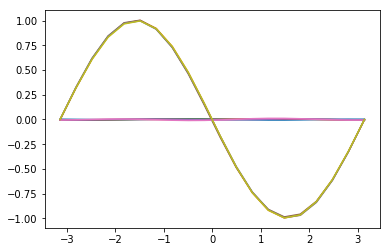

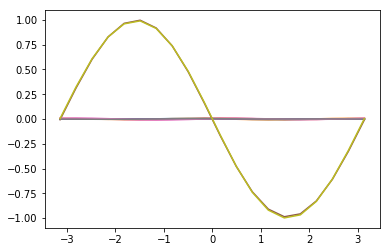

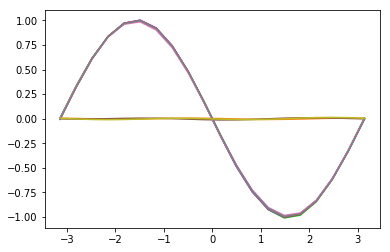

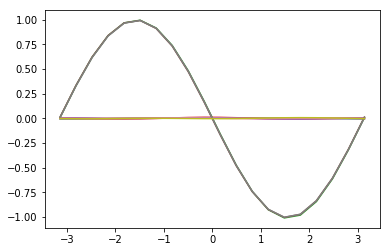

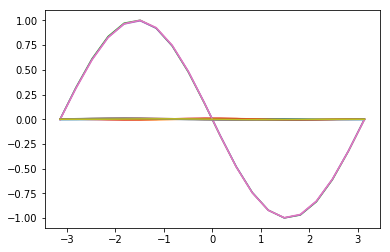

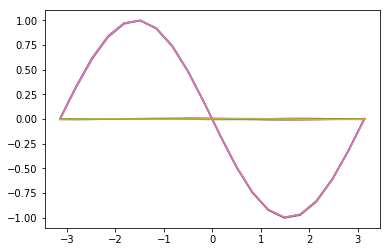

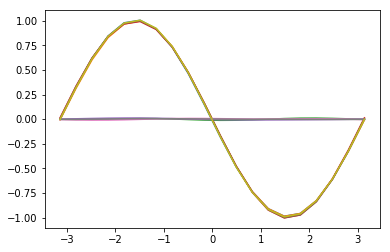

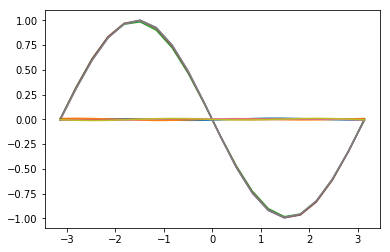

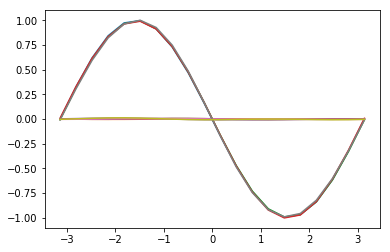

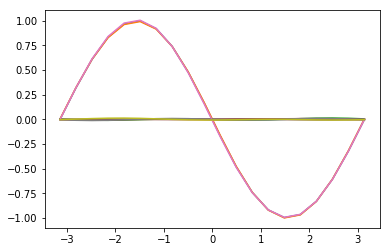

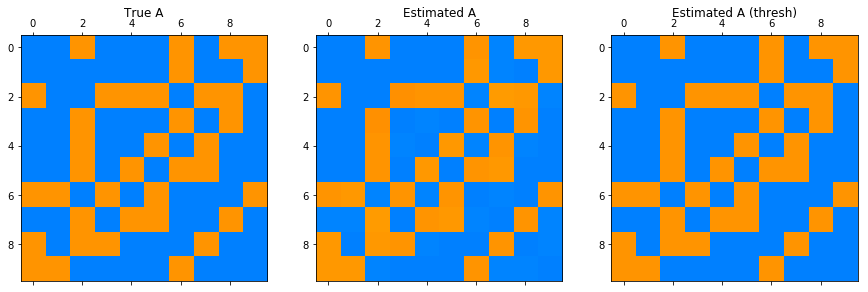

(array([ 0.26532585, -0.14794963,  0.53990149,  0.18913765,  0.04072382,
        -0.29303814,  0.41904593, -0.72999328, -0.08983052, -0.30190014]),
 array([[0.        , 0.00612137, 1.00158144, 0.00768144, 0.00469841,
         0.00586797, 1.00420835, 0.01152484, 0.99823978, 0.99747159],
        [0.00612137, 0.        , 0.00726586, 0.00213852, 0.00758734,
         0.00220048, 0.99734718, 0.01104154, 0.00319164, 0.99903639],
        [1.00158144, 0.00726586, 0.        , 1.00883188, 1.00148563,
         1.0003788 , 0.01217191, 0.98526158, 0.99608571, 0.0135471 ],
        [0.00768144, 0.00213852, 1.00883188, 0.        , 0.01056984,
         0.00755213, 1.00352582, 0.00423127, 1.00184048, 0.00683393],
        [0.00469841, 0.00758734, 1.00148563, 0.01056984, 0.        ,
         0.9984101 , 0.01098161, 1.00139478, 0.00985652, 0.00382892],
        [0.00586797, 0.00220048, 1.0003788 , 0.00755213, 0.9984101 ,
         0.        , 1.00165215, 0.99940954, 0.00718721, 0.00505059],
        [1.0042083

In [14]:
with_symmetry=True
A,b=generate_Ab(phases,vel,learning_params)
if with_symmetry:
    B,c=get_symmetry_constraints(learning_params)
    newA,newb=get_combined_matrix(A,b,B,c)
else:
    newA,newb=get_combined_matrix(A,b)
x=solve_system(newA,newb,learning_params)
unpack_x(x,learning_params,show_coup_plots=True)